# The Grestest Senstivity Mapper Demo

This demo will consist of three examples for runing the sensitivity mapper.
1. A single pointing and comparison to SITE
2. Setting up a simple map by hand
3. Reading in an AOR file created by USPOT

First we import the required python libraries

In [1]:
import sens_map_lib #main library for the sensitivity mapper
import numpy as np #numpy
from astropy.modeling import models #For generating synthetic signal on the sky
from matplotlib import pyplot as plt #For plotting

## Demo 1 - A single pointing and comparison to SITE for an HFA observation of the [O I] line

Here we will run a single pointing.  We will use SITE to get our noise estimate and also we will compare our results to SITE.  If everything runs correctly, SITE and the sensitivty mapper should give us the same result.

The first step is to set up a "sky" object which is a wrapper for the 2D array of pixels that represent the spatially resolved signal, exposure, data, and noise on the sky.    Pixel coordinates are in arcseconds.  In general, the sky object needs to be big enough to cover your maps.  Pixel sizes should start out small (~0.1"-1") which can be later regridded to larger pixel sizes.

Below we define a sky object that is 60"x60" centered at zero with a pixel size of 0.5".  The first arguments give the range of x and y in arcsec and the third argument is the pixel size or plate scale.

In [2]:
skyobj = sens_map_lib.sky([-30.0,30.0], [-30.0, 30.0], 0.5)

A sky object consists of four 2D arrays that store the following:
1. Signal
2. Exposure
3. Noise
4. Data

The first step is to define what we think the signal on the sky looks like.  This will populate the `signal` array.  Since this is a single pointingm, we will give the sky a uniform background of $T_a = 5 K$.  For uniform signals, there is a special `signal` method.  You can explicitely define what you think the signal on the sky is by setting `skyobj.signal =`.  Astropy models work well for this.

In [3]:
skyobj.uniform(5.0)

Now we will plot the signal for `skyobj` with a special `plot` argument.  Note the spatial coordinates are 60"x60" centered at 0,0 and the signal is a uniform 5 K, exactly as we defined. 

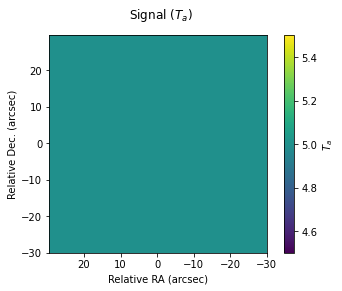

In [4]:
skyobj.plot('signal')

Since we want to simualte a single pointing observation with the HFA, we need to set up a `GREAT_array` object for the HFA.  GREAT_array has child classes for each array.  Here we will set up the HFA child class `HFA_array`.  We also will explicitely define the freqeuncy of the line in Hz here.  Later we will see how we can read in AORs which will handle creating `GREAT_array` object automatically.

In [5]:
hfa_array = sens_map_lib.HFA_array(freq=4.74477749e12)

Now we will define our observation by passing `skyobj` to `hfa_array` with the `single_point` method.  This passes the necessary information about this pointing/map to `skyojb` for later processing.  You can reapeat this for as many pointings or maps as necessary, but for this demo we just going to define a single pointing at an RA and Dec of 0,0 with an exposure time of 100 seconds and 1 cycle.  We will not rotate the array angle.

In [6]:
hfa_array.single_point(skyobj, x=0., y=0., array_angle=0., time=100.0, cycles=1)

Next we will figure out the noise level.  In order to do this we need the system temperature $(T_{sys})$ which can be calculated using the SOFIA Instrument Time Estimator (SITE).  For now we will use SITE to estimate $T_{sys}$ but keep it open because we will be comparing our final results to SITE at the end.

Do the following:
 * Go to SITE: https://dcs.arc.nasa.gov/proposalDevelopment/SITE/index.jsp
 * Under Spectropic Time Estimators and Tools, select GREAT
 * Set the rest frequency to 4.7447749 THz, which is the frequency for the HFA tuned to the [O I] line
 * Leave the Frequency/Velocity Resolution at 1.0 km/s
 * Leave the Line Width at 500.0 MHz
 * Set the Type of Observation to SinglePoint or BeamSwitch OTF/Raster Map
 * Leave Observer Velocity at 0.0 km/s
 * Set the Calculation Method to Total Integration Time and set the time to 100.0 seconds
 * Under Astronomical Source Definition, set the Bright Temprature $T_R^*(K)$ to 5.0 and leave the Source Velocity 0.0 km/s
 * Leave the Observing Condition Constraints as their default, 40 degree Elevation Angle, an Altitude of 41000 feet, and the Zenith Water Vapor set to 7.3 um.
 
SITE should look like this:
 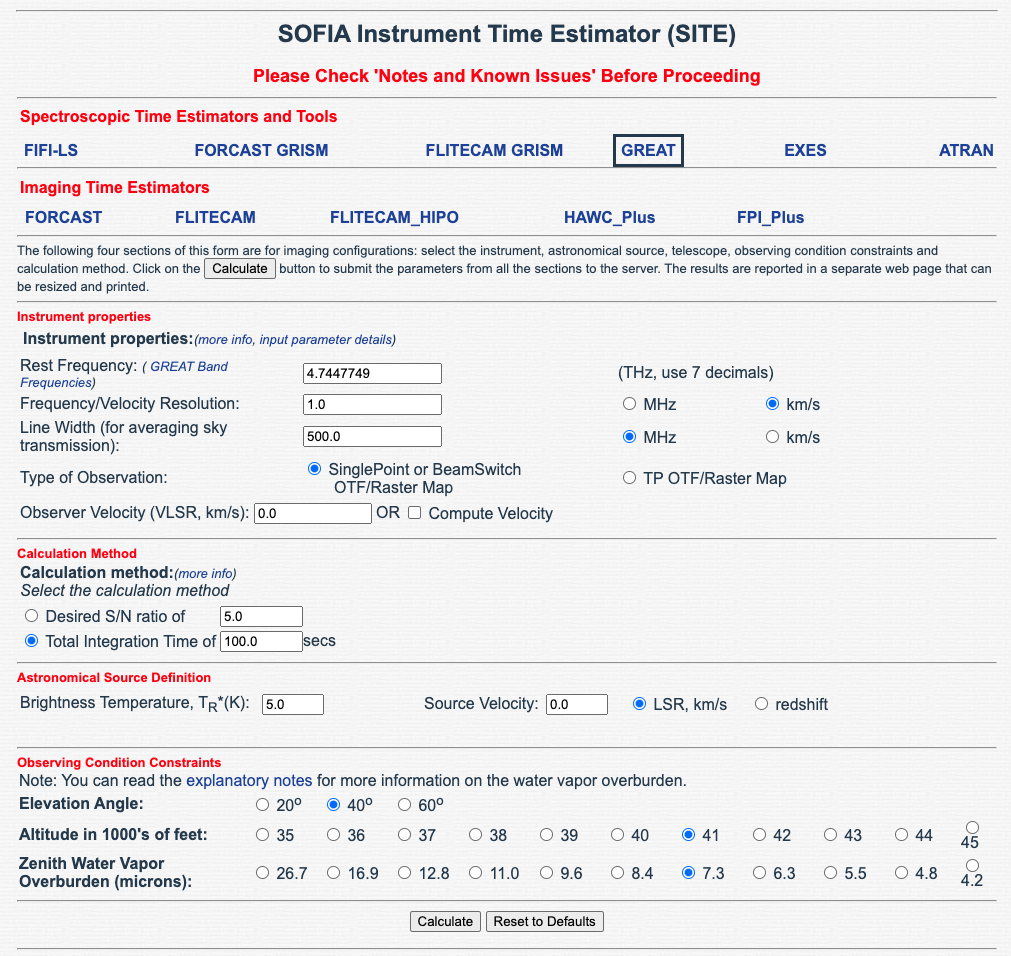

 
Now click Calculate, the resulting page should look like this:
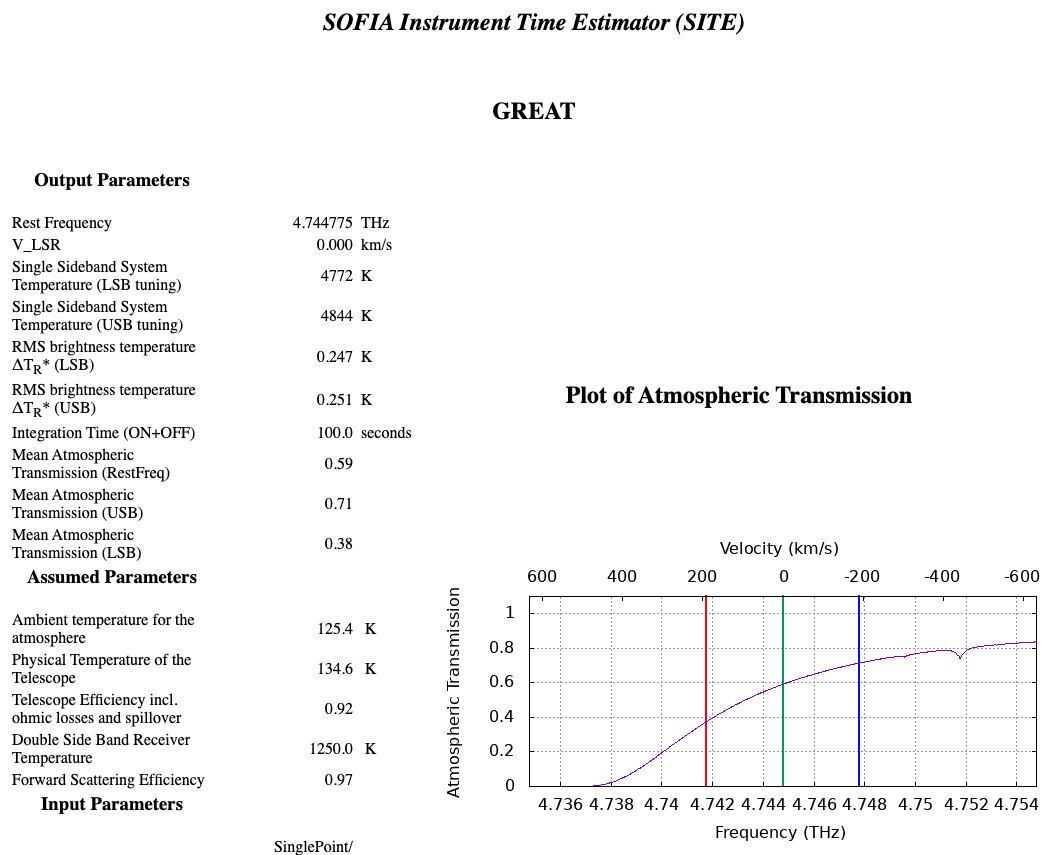
As you can see, the [O I] line lies on the edge of a large telluric absorption feature (we will come back to this later).  Here we will use the Single Side System Temperature (LSB tuning) of 4772 K which we set in skyobj as follows.

Now that we have our noise level, we will simulate the observations using the `simulate_observation` method of `skyobj`, which will take all the information on the pointings fed to `skyobj` by `hfa_array` and generate the resulting exposure, noise, and data maps.  This is where we set the noise level $T_{sys} = 4772 K$.  We also set our spectral resolution element here with either the `deltafreq` or `deltav` command which sets the resolution in Hz or km/s respectively.  Here we set `deltav=1.0` for 1 km/s resolution.

In [7]:
skyobj.simulate_observation(Tsys = 4772.0, deltav=1.0)

Total beam signal: 34.99999999999992
Total beam noise: 4.443036866101191
Total beam S/N: 7.877494843006507
total signal = 72000.0
total noise =  1.5575815082360934e+118
Total S/N:  3.852125855548189e-116


Now let us look at the exposure map which gives the spatially resolved exposure time

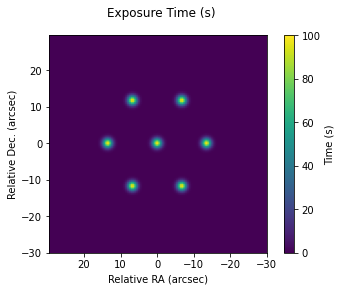

In [8]:
skyobj.plot('exposure')

Here you can see the hexagonal footprint of the seven HFA beams on the sky.  The exposure map is created by treating each beam as a point source with the given exposure time  and convolutionally regridding it onto the sky using a kernal that is a gaussian with 1/3 the FWHM of the beam size.  One thing to keep in mind is that because there are seven beams, the total exposure here is really 7x that of the calculations used on SITE.

Now let us look at the noise map.

Min. noise =  0.2399014410937864


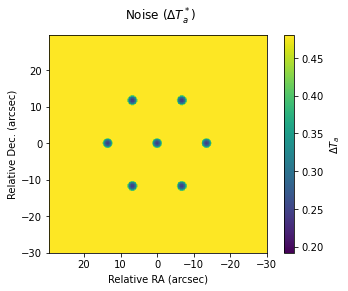

In [9]:
print('Min. noise = ', np.min(skyobj.noise))
skyobj.plot('noise')

The noise is calculated using the same equations as SITE, except we apply it to the whole exposure time map instead of a single beam.  Since GREAT/SOFIA is background limited, we do not need to take into account the poisson noise from the signal.  The noise map looks like a negative of the exposure time map.  The noise is lowest at the center of each beam and quickly goes up the further away you are from the beam center.  Here we also print the minimum noise so you can see what it is at the center of each beam on the sky.

What about the data?  The signal we defined at the beginning is convolved with the profile of each beam to determine how much signal each beam picks up, the resulting singals detected by each beam are then convolutionally regridded back onto the sky and the result is this data map.

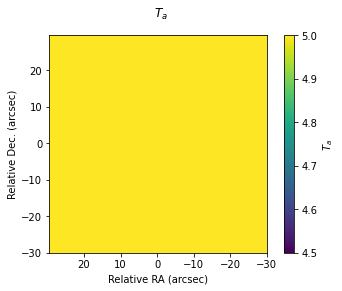

In [10]:
skyobj.plot('data')

As you can see, the result is uniform and $T_a = 5 K$ just like the signal we inputted.  This is exactly what we would expect.

What is our signal-to-noise ratio?  We can make a S/N map by dividing the `data` by the `noise`.  The `skyobj` already has this built into its plotting function as you can see.

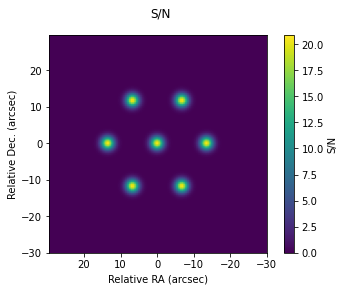

In [11]:
skyobj.plot('s2n')

The peak S/N is about 20.0. 

NOTE: When dealing with S/N maps, one must distinguish between the spatially resolved S/N and the integrated S/N.  Integrating the S/N for a map requires careful consideration of how you mask out unwanted pixels.  Schemes such as optimal extraction or Voronoi binning might also work.  Bad masks will include pixels with lots of noise (remember the noise increases to infinity outside any beam profile coverage) leading to very low integrated S/N measurements.

Now let us compare to the results from SITE which gives the following
RMS brightness temperature ΔTR* (LSB) = 0.247 K.
Again we take the minimum of the noise map.

In [12]:
print('Min noise: ', np.min(skyobj.noise))

Min noise:  0.2399014410937864


You can see the noise is slighgtly higher for SITE.  This is likely due to this program assuming perfect telescope efficiency, while SITE includes a correction factor.

Now let us compare our exposure time to what is calculated on SITE.  We have a max S/N of:

In [13]:
print('Max S/N = ', np.max(skyobj.data/skyobj.noise))

Max S/N =  20.8418923087889


Go back to SITE and change the Calculation Method from Total Integration Time to Desired S/N and set it to 20.8.
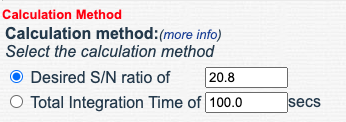



This results in an estimated integration time of 105.9 seconds.
which is slightly higher than our 100.0 second integration time, most likely due to the fact that the [O I] line sites on the edge of a telluric absorption feature so the atmospheric transmission is less than 1.0.
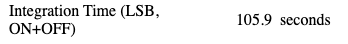

We have demonstraited in this demo that for a single pointing, both SITE and this program give almost the same results, ignoring small losses due to telescope efficiency or atmospheric transmission.  In the next demo, we will walk through creating a map.